# A short notebook to explore the UK power usage and any affect from lockdwon in 2020.

Key questions:

1) What is the power usage across the data set provided?

2) What regular pattern can be seen in the data, i.e. seasonality?

3) Is there any affect on power load from lockdown?

Import data set and libraries

In [1]:
# Import som libraries for some data wrangling
import pandas as pd
import numpy as np

In [2]:
#Import first data set, let's start with GB and see what we have
df_power_GB = pd.read_csv(r'C:\Users\andy_\OneDrive\Data Science\Energy Consumption Data Files\archive\gb.csv')

#Check head
df_power_GB.head()

,start,end,load
0,2015-01-01 00:00:00+00:00,2015-01-01 00:30:00+00:00,27123.0
1,2015-01-01 00:30:00+00:00,2015-01-01 01:00:00+00:00,26758.0
2,2015-01-01 01:00:00+00:00,2015-01-01 01:30:00+00:00,27561.0
3,2015-01-01 01:30:00+00:00,2015-01-01 02:00:00+00:00,26770.0
4,2015-01-01 02:00:00+00:00,2015-01-01 02:30:00+00:00,25318.0


In [3]:
#Check tail
df_power_GB.tail()

,start,end,load
97809,2020-07-31 21:30:00+00:00,2020-07-31 22:00:00+00:00,26433.0
97810,2020-07-31 22:00:00+00:00,2020-07-31 22:30:00+00:00,25198.0
97811,2020-07-31 22:30:00+00:00,2020-07-31 23:00:00+00:00,23864.0
97812,2020-07-31 23:00:00+00:00,2020-07-31 23:30:00+00:00,23336.0
97813,2020-07-31 23:30:00+00:00,2020-08-01 00:00:00+00:00,22488.0


Perform some data wrangling to get it all ship shape and ready for some exploratory data analysis

In [4]:
#Next I need to format the date and time columns:

    #Drop time from 'start' and 'end' and Split column into multiple columns by delimiter   
df_power_GB_Start = df_power_GB['start'].str.split(' ', expand=True)
    #Drop time column
df_power_GB_Start = df_power_GB_Start.drop(columns=[1])
    #Merge to df_power_GB
df_power_GB = df_power_GB.join(df_power_GB_Start)
    #Drop existing 'start'and 'end' from df_power_GB
df_power_GB = df_power_GB.drop(columns=['start', 'end'])
    #change column 0 name to 'Date'
df_power_GB = df_power_GB.rename(columns={0: "Date"})
    #Check the output
df_power_GB.head()

,load,Date
0,27123.0,2015-01-01
1,26758.0,2015-01-01
2,27561.0,2015-01-01
3,26770.0,2015-01-01
4,25318.0,2015-01-01


In [5]:
df_power_GB.tail()

,load,Date
97809,26433.0,2020-07-31
97810,25198.0,2020-07-31
97811,23864.0,2020-07-31
97812,23336.0,2020-07-31
97813,22488.0,2020-07-31


In [6]:
#Looks good. Now to check if the data set is complete
missing_data = df_power_GB.isnull()

for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")    

load
False    97814
Name: load, dtype: int64

Date
False    97814
Name: Date, dtype: int64



In [7]:
#Great no missing data but I need to format the date column
df_power_GB['Date'] = pd.to_datetime(df_power_GB['Date'])
#check output
df_power_GB.dtypes

#create new df GB2
df_power_GB2 = df_power_GB

#Assign Year-Week Num Ref
df_power_GB2['Year'] = df_power_GB2['Date'].dt.year
df_power_GB2['Month'] = df_power_GB2['Date'].dt.month
df_power_GB2['Month'] = df_power_GB2['Month'].apply('{0:0>2}'.format)
df_power_GB2['Week'] = df_power_GB2['Date'].dt.week
df_power_GB2['Week'] = df_power_GB2['Week'].apply('{0:0>2}'.format)
#Add new columns to index
df_power_GB2.set_index(['Year','Month','Week'], append=True)

df_power_GB2.head()

<ipython-input-7-c60c86af1096>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_power_GB2['Week'] = df_power_GB2['Date'].dt.week


,load,Date,Year,Month,Week
0,27123.0,2015-01-01,2015,01,01
1,26758.0,2015-01-01,2015,01,01
2,27561.0,2015-01-01,2015,01,01
3,26770.0,2015-01-01,2015,01,01
4,25318.0,2015-01-01,2015,01,01


With the data wrangling now complete, I will perform some EDA to answer my questions.

Q1. What is the UK's power load over the period?

In [8]:
#First I would like to Group data by Year, Month, Week to make it easier to look at
df_power_GB2 = df_power_GB2[['Year','Month','Week','load']]
df_power_GB2 = df_power_GB2.groupby(['Year','Month','Week'],as_index=False).sum()
df_power_GB2['Year'] = df_power_GB2['Year'].apply(str)
df_power_GB2['Year-Month'] = df_power_GB2["Year"] + '.' + df_power_GB2["Month"]
df_power_GB2.head()

,Year,Month,Week,load,Year-Month
0,2015,01,01,5812925.0,2015.01
1,2015,01,02,13507853.0,2015.01
2,2015,01,03,14515654.0,2015.01
3,2015,01,04,15008103.0,2015.01
4,2015,01,05,12875767.0,2015.01


<AxesSubplot:xlabel='Year-Month'>

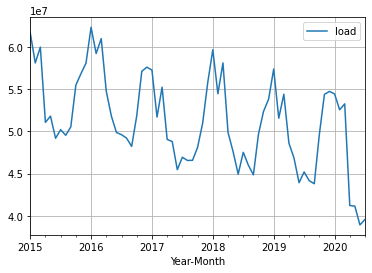

In [9]:
#To explore the seasonality clearly I will group the data by year-month and use decomposition model to explore the data

#create new df from df_power_GB
df_power_GB_MTH = df_power_GB2

#Set data type on new column
df_power_GB_MTH['Year-Month'] = pd.to_datetime(df_power_GB_MTH['Year-Month'])

#group the data by Year-Month
df_power_GB_MTH = df_power_GB2.groupby(['Year-Month'],as_index=True).sum()

#Plot results
import matplotlib.pyplot as plt
df_power_GB_MTH.plot(grid=True)

As we can see from the above we are looking at a peak of just above 6 and a general trend downwards towards 4 in the summer of 2020. To look in a little more detail see below.

In [22]:
df_power_GB_MTH.describe()

,load
count,6.700000e+01
mean,5.123524e+07
std,5.500264e+06
min,3.891462e+07
25%,4.755959e+07
50%,5.099738e+07
75%,5.500174e+07
max,6.235820e+07


Q2. What does the seasonailty of the data look like?

For this I will use a decomposition model from statsmodels. It's a really useful tool and will show the data trends in my data set.

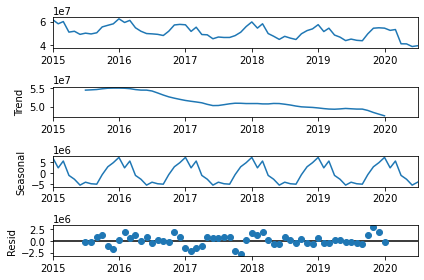

In [10]:
#Import statsmodels and matplot lib, create 'additive' decomposition model and see the output

import statsmodels.api as sm
import matplotlib
decomposition = sm.tsa.seasonal_decompose(df_power_GB_MTH, model = 'additive')
fig = decomposition.plot()
matplotlib.rcParams['figure.figsize'] = [30.0, 5.0]

As we can see from the 'Decomposition' model there is an overall downward trend in power usage over the last five years (see graph two).

We can also see that there is consistant seasonal power usage, clearly this will be related to changes in the weather over the summer months (see graph three).

Q3. Given the above what does the COVID lockdown do to the data?

First I'll pull in the COVID-19 Data and find the UK locdown start date.

In [11]:
#Load COVID Lockdown data set
df_lockdown = pd.read_csv(r'C:\Users\andy_\OneDrive\Data Science\COVID 19 Lockdown Dates\archive\countryLockdowndates.csv')

#Check head
df_lockdown.head()

,Country/Region,Province,Date,Type,Reference
0,Afghanistan,NaN,24/03/2020,Full,https://www.thestatesman.com/world/afghan-govt...
1,Albania,NaN,08/03/2020,Full,https://en.wikipedia.org/wiki/2020_coronavirus...
2,Algeria,NaN,24/03/2020,Full,https://www.garda.com/crisis24/news-alerts/325...
3,Andorra,NaN,16/03/2020,Full,https://en.wikipedia.org/wiki/2020_coronavirus...
4,Angola,NaN,24/03/2020,Full,https://en.wikipedia.org/wiki/2020_coronavirus...


In [12]:
#Lets locate and isolate UK data
df_lockdown_UK = df_lockdown[df_lockdown['Country/Region'] == 'United Kingdom']
df_lockdown_UK

,Country/Region,Province,Date,Type,Reference
235,United Kingdom,Anguilla,18/03/2020,Full,https://en.wikipedia.org/wiki/2020_coronavirus...
236,United Kingdom,Bermuda,NaN,None,NaN
237,United Kingdom,British Virgin Islands,NaN,None,NaN
238,United Kingdom,Cayman Islands,NaN,None,NaN
239,United Kingdom,Channel Islands,NaN,None,NaN
240,United Kingdom,Gibraltar,24/03/2020,Full,https://www.theolivepress.es/spain-news/2020/0...
241,United Kingdom,Isle of Man,23/03/2020,Full,https://en.wikipedia.org/wiki/2020_coronavirus...
242,United Kingdom,Montserrat,NaN,None,NaN
243,United Kingdom,Turks and Caicos Islands,27/03/2020,Full,https://en.wikipedia.org/wiki/2020_coronavirus...
244,United Kingdom,NaN,23/03/2020,Full,https://www.businessinsider.com/countries-on-l...


In [13]:
#A few here and we only want UK so i'll need to be more specific, as I need index 244 'NaN' I can just select that
df_lockdown_UK = df_lockdown.loc[244]
df_lockdown_UK = pd.DataFrame(df_lockdown_UK)
df_lockdown_UK

,244
Country/Region,United Kingdom
Province,NaN
Date,23/03/2020
Type,Full
Reference,https://www.businessinsider.com/countries-on-l...


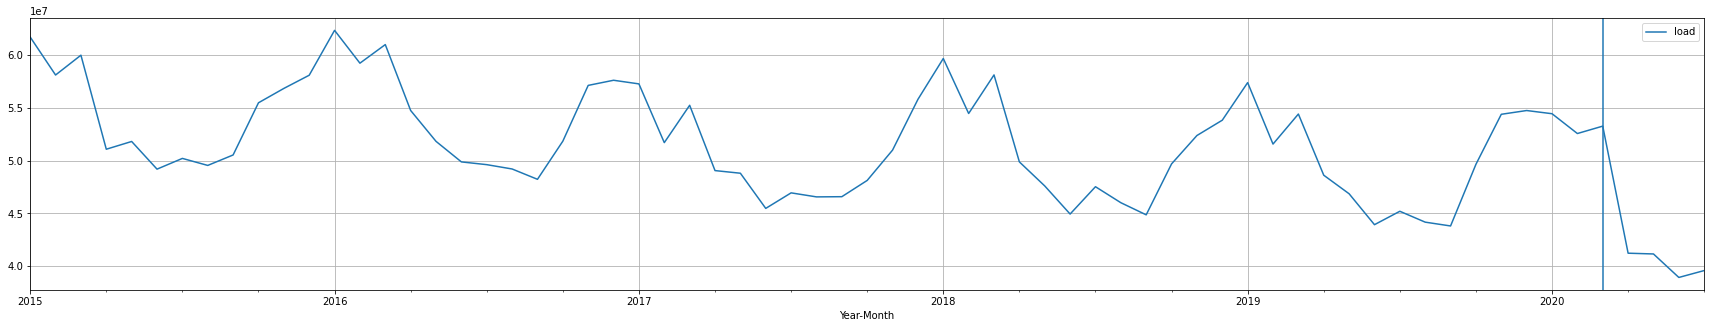

In [14]:
#Now I have my lockdown date I can plot this on a graph with the five years of data and see what that looks like
import matplotlib.pyplot as plt
df_power_GB_MTH.plot(grid=True)
plt.axvline(x='2020-03-23')

At first glance there seems to be an abnormal fall in power load at the same time a lockdown. It dooes not follow the usual pattern of the last five years. Below I'll oook in a little more detail to see if this is indeed the case.

To do this I'll simply take a look at the percentage change month to month from the same period each year.

In [15]:
#Get table with percentage change
df_power_GB_MTH_pct = df_power_GB_MTH.pct_change()
df_power_GB_MTH_pct['Year-Month'] = df_power_GB_MTH_pct.index
df_power_GB_MTH_pct.head()

,load,Year-Month
Year-Month,,
2015-01-01,NaN,2015-01-01
2015-02-01,-0.058300,2015-02-01
2015-03-01,0.032351,2015-03-01
2015-04-01,-0.148699,2015-04-01
2015-05-01,0.014396,2015-05-01


In [16]:
#Isolate the period of interest
array = ['2015-04-01', '2016-04-01', '2017-04-01', '2018-04-01', '2019-04-01', '2020-04-01']
df_power_GB_MTH_pct_2 = df_power_GB_MTH_pct.loc[df_power_GB_MTH_pct['Year-Month'].isin(array)]
df_power_GB_MTH_pct_2

,load,Year-Month
Year-Month,,
2015-04-01,-0.148699,2015-04-01
2016-04-01,-0.102499,2016-04-01
2017-04-01,-0.112151,2017-04-01
2018-04-01,-0.141964,2018-04-01
2019-04-01,-0.106669,2019-04-01
2020-04-01,-0.226319,2020-04-01


In [17]:
#Describe data
df_power_GB_MTH_pct_2.describe()

,load
count,6.000000
mean,-0.139717
std,0.046525
min,-0.226319
25%,-0.147015
50%,-0.127057
75%,-0.108039
max,-0.102499


From the above I can clearly see that the drop in april 2020 was significantly higher than the average for the data set. This would suggest that there is an effect of lockdown felt in 2020.

To be sure that it was not just a fast drop but ultimately at the same level I'll need to take a look across the full drop period and see the result. If I look closely at the graph data by month I can see that the dro range for the season is '03-06' for four out of the five months so this will be okay to use as out basis is we consider 2016 to be an outlier.

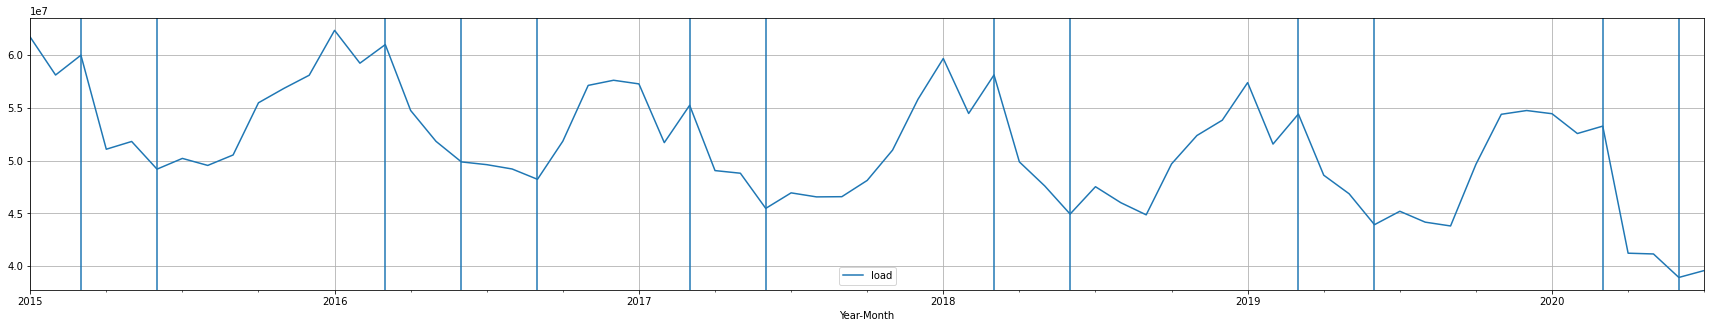

In [18]:
df_power_GB_MTH.plot(grid=True)
plt.axvline(x='2015-03')
plt.axvline(x='2015-06')

plt.axvline(x='2016-03')
plt.axvline(x='2016-06')
plt.axvline(x='2016-09')

plt.axvline(x='2017-03')
plt.axvline(x='2017-06')

plt.axvline(x='2018-03')
plt.axvline(x='2018-06')

plt.axvline(x='2019-03')
plt.axvline(x='2019-06')

plt.axvline(x='2020-03')
plt.axvline(x='2020-06')

Looking at the overall drop for the period above. I expect to see somewhere in the region of a 33% additional decrease compared to the prviouse five years.

In [19]:
df_power_GB_MTH_pct_3 = df_power_GB_MTH.pct_change(periods=3)
df_power_GB_MTH_pct_3['Year-Month'] = df_power_GB_MTH_pct_3.index
df_power_GB_MTH_pct_3.head()

,load,Year-Month
Year-Month,,
2015-01-01,NaN,2015-01-01
2015-02-01,NaN,2015-02-01
2015-03-01,NaN,2015-03-01
2015-04-01,-0.172396,2015-04-01
2015-05-01,-0.108507,2015-05-01


In [20]:
array = ['2015-06-01', '2016-06-01', '2017-06-01', '2018-06-01', '2019-06-01', '2020-06-01']
df_power_GB_MTH_pct_3 = df_power_GB_MTH_pct_3.loc[df_power_GB_MTH_pct_3['Year-Month'].isin(array)]
df_power_GB_MTH_pct_3

,load,Year-Month
Year-Month,,
2015-06-01,-0.180187,2015-06-01
2016-06-01,-0.182443,2016-06-01
2017-06-01,-0.177069,2017-06-01
2018-06-01,-0.227082,2018-06-01
2019-06-01,-0.192916,2019-06-01
2020-06-01,-0.269508,2020-06-01


In [21]:
df_power_GB_MTH_pct_3.describe()

,load
count,6.000000
mean,-0.204867
std,0.036604
min,-0.269508
25%,-0.218540
50%,-0.187680
75%,-0.180751
max,-0.177069


A look at the above data tells us that over the period the mean load decrease from 03-06 was 20.5% while the load decrease for 2020 during the lockdwon period was 27.0%. So we have an additional drop in load over the lockdown period of 6.5 percnetager points.